<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/6205A/6205A3Q1Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Goals 


We will train a  a feedforward neural network that can classify CIFAR10 image set into classes. 

## Import libraries

In [53]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# TF.Dataset

We will load data from tensorflow_datasets. The data is loaded as TF.Datasets. It has in-built methods to implement cache and pre-fetch to increase the training speed.

In [54]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:100%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [55]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

## Explore the data

### View the Data

 > Method 1: This command converts the dataset as a dataframe, and hence is useful to work using pandas library as well as for visualization.





,image,label
0,,7 (horse)
1,,8 (ship)
2,,4 (deer)
3,,4 (deer)

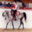
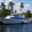
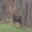
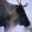

In [56]:
tfds.as_dataframe(ds_train.take(4), ds_info) #method 1

> Method 2: This is in-built menthod to show the tfds examples.

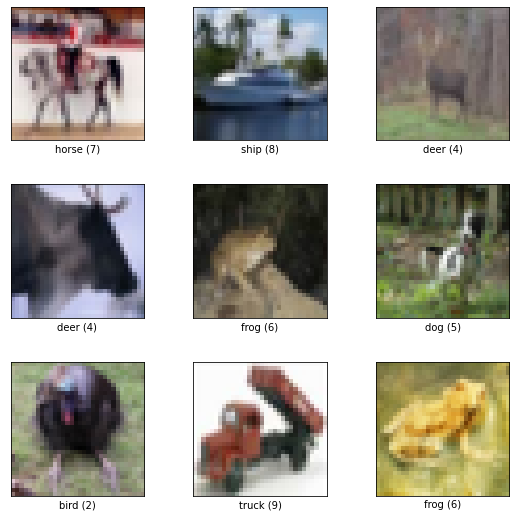

In [57]:
fig = tfds.show_examples(ds_train, ds_info) #method 2

### Dataset

The data is loaded as a tuple of TFDatasets, train and test, each containing n number of tuples of tensors, representing images with (32, 32, 3) tensor and label with scaler ()

In [58]:
ds_train 

<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>

> .take(n) method returns n number of examples, and so can be used to select a part of datasets.

In [59]:
 for image,label in ds_train.take(1):     #This is a way to access the image and label in ds_train. They are of shape
  print(label)

tf.Tensor(7, shape=(), dtype=int64)


In [60]:
for img, lbl in ds_train.take(1): #This is not a tensor of shape containg the number of elements
  print(img.shape)

(32, 32, 3)


> To check the cardinality of a dataset.

In [61]:
ds_train.cardinality() # Number of examples

<tf.Tensor: shape=(), dtype=int64, numpy=45000>

In [62]:
ds_val.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=5000>

### Input Pipilines

We will built pipelines that take in raw tfds datasets and prepare them for training.

> First we need to normalize the images as smaller values are more stable for tining neural networks.

In [63]:
def normalize_img(imag, label):
  return tf.cast(imag, tf.float32) / 255., label 

In [64]:
ds_train = ds_train.map(       
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [65]:
ds_train = ds_train.cache() #Cache the whole data in a the memory. Should be run over all data to be finalised. Returns a dataset
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples) # Shuffle the data in the dtaset, set buffer_size to be equal to the number of elements of type dataset. Returns a Dataset.
ds_train = ds_train.batch(128) #Batches the examples in the Dataset to form new tensors each having an external dimension represnting the batch_size. The last tensor might have a different batch size if b_s does not divide total examples.
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE) #You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

Notice that the images in ds_train are now tensors with shape containing the batches. The type of ds_train is a PrefetchDataset

In [66]:
for img, lbl in ds_train.take(1):
  print(img.shape)

(128, 32, 32, 3)


In [67]:
ds_train

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>

In [68]:
ds_val = ds_val.map(       
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [69]:
ds_val = ds_val.cache() #Cache the whole data in a the memory. Should be run over all data to be finalised. Returns a dataset
ds_val = ds_val.shuffle(ds_info.splits['train'].num_examples) # Shuffle the data in the dtaset, set buffer_size to be equal to the number of elements of tyhe dataset. Returns a Dataset.
ds_val = ds_val.batch(128) #Batches the examples in the Dataset to form new tensors each having an external dimension represnting the batch_size. The last tensor might have a different batch size if b_s does not divide total examples.
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE) #You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [75]:
ds_test = ds_test.map(
    normalize_img,num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()   #Here caching is done before the batching. and no shuffle
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# Model

 Step 3: Create the model Arguments:
>**shape**: A shape tuple (integers), not including the batch size.
For instance, shape=(32,) indicates that the expected input
will be batches of 32-dimensional vectors. Elements of this tuple  can be None; 'None' elements represent dimensions where the shape is not known.

> **batch_size**: optional static batch size (integer).

In [71]:
#
model = tf.keras.models.Sequential([
 # tf.keras.Input(shape=(32,32,3)), not necessary as not a layer, instead of this pass input shape in first layer
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='sparse_categorical_crossentropy', #Change to Categorical_crossentropy for multiple output data
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy','mse'],
)

# Summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Step 4: Train the model
hist = model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_val,
)

Epoch 1/25
352/352 [==============================] - 5s 13ms/step - loss: 2.0719 - accuracy: 0.2515 - mse: 27.2402 - val_loss: 1.8187 - val_accuracy: 0.3498 - val_mse: 28.8139
Epoch 2/25
352/352 [==============================] - 3s 10ms/step - loss: 1.8090 - accuracy: 0.3610 - mse: 27.3409 - val_loss: 1.7335 - val_accuracy: 0.3920 - val_mse: 28.8166
Epoch 3/25
352/352 [==============================] - 3s 10ms/step - loss: 1.7402 - accuracy: 0.3874 - mse: 27.4399 - val_loss: 1.7430 - val_accuracy: 0.3776 - val_mse: 28.8190
Epoch 4/25
352/352 [==============================] - 3s 9ms/step - loss: 1.6813 - accuracy: 0.4089 - mse: 27.5973 - val_loss: 1.6427 - val_accuracy: 0.4244 - val_mse: 28.8191
Epoch 5/25
352/352 [==============================] - 3s 10ms/step - loss: 1.6372 - accuracy: 0.4230 - mse: 27.4413 - val_loss: 1.6020 - val_accuracy: 0.4342 - val_mse: 28.8223
Epoch 6/25
352/352 [==============================] - 3s 10ms/step - loss: 1.6150 - accuracy: 0.4286 - mse: 27.5890 

>We can plot the accuracy on training and validation data. It is a great quick tool, to evaluate the model. If validation accuracy is diverging away, it is an indicator that modle is overfitting.

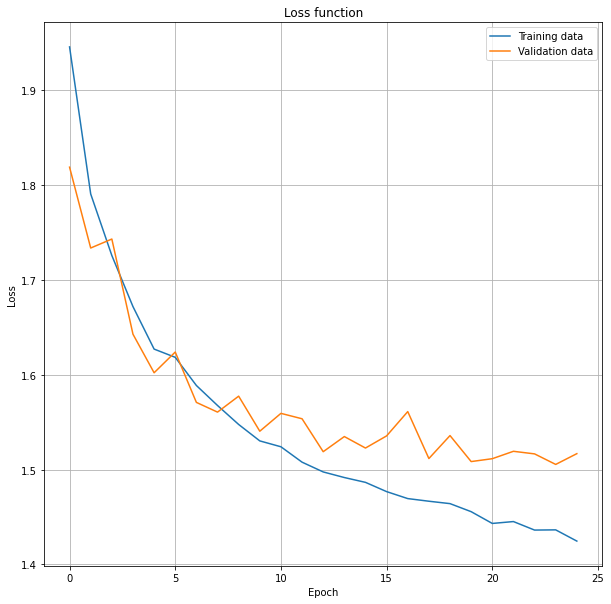

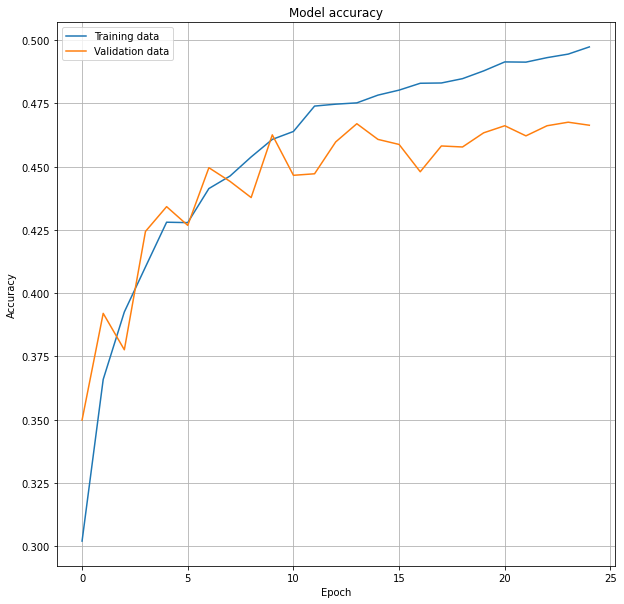

In [73]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

In [76]:
model.evaluate(ds_test)

79/79 [==============================] - 3s 36ms/step - loss: 2.5222 - accuracy: 0.1000 - mse: 27.6146


[2.522242546081543, 0.10000000149011612, 27.614564895629883]

## Prediction

> The model is trained to output probability for a given example to belong to one of the ten classes.

In [ ]:
model.predict(ds_test)

In [ ]:
ds_prediction= model.predict_classes(ds_test)

In [ ]:
ds_prediction

> Predict the classes

In [ ]:
prediction = np.argmax(model.predict(ds_test), axis=-1) # model.predict_classes is being deprecated

In [ ]:
prediction.shape

> We observe that now to use the classification reports and do more after training analysis, it is easier to work with array. Additionally ds_test ds_train are now divided in batches in prefetch datasets making post training analysis a bit harder. We will in last section use np.arrays.

In [89]:
ds_test

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>

In [90]:
ds_test.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=79>

In [91]:
y_lbl = np.array(list(ds_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [92]:
y_lbl.shape

(79, 2)

# Experiment with model architecture

## Add more layers

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy', 'mse'],
)

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 427,658
Trainable params: 427,658
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Here we are using TFdataset as an input of model.fit. The dataset has tuple of tensors, the image, label respectively. We can also input a tensor with shape (50000,32,32)

In [ ]:
hist = model.fit(
    ds_train,
    epochs=25,
    validation_data=ds_val, 
)

Epoch 1/25
352/352 [==============================] - 4s 10ms/step - loss: 2.0344 - accuracy: 0.2489 - mse: 27.4564 - val_loss: 1.7464 - val_accuracy: 0.3730 - val_mse: 28.8167
Epoch 2/25
352/352 [==============================] - 3s 9ms/step - loss: 1.7316 - accuracy: 0.3820 - mse: 27.3920 - val_loss: 1.6493 - val_accuracy: 0.4108 - val_mse: 28.8176
Epoch 3/25
352/352 [==============================] - 3s 9ms/step - loss: 1.6446 - accuracy: 0.4134 - mse: 27.6382 - val_loss: 1.6244 - val_accuracy: 0.4186 - val_mse: 28.8236
Epoch 4/25
352/352 [==============================] - 3s 9ms/step - loss: 1.5765 - accuracy: 0.4375 - mse: 27.4112 - val_loss: 1.5794 - val_accuracy: 0.4332 - val_mse: 28.8220
Epoch 5/25
352/352 [==============================] - 3s 9ms/step - loss: 1.5175 - accuracy: 0.4568 - mse: 27.4507 - val_loss: 1.5243 - val_accuracy: 0.4548 - val_mse: 28.8263
Epoch 6/25
352/352 [==============================] - 3s 9ms/step - loss: 1.4871 - accuracy: 0.4702 - mse: 27.6026 - va

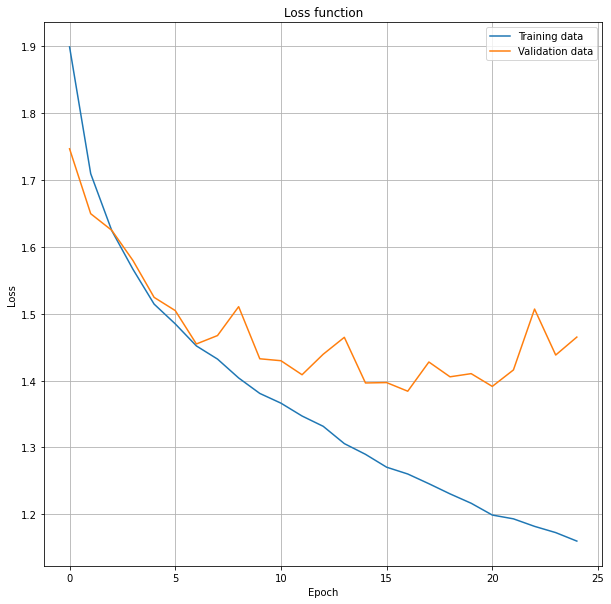

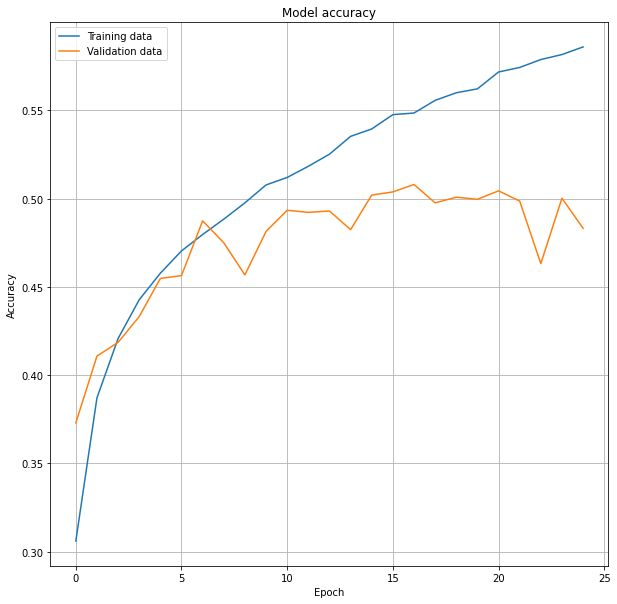

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

In [ ]:
model.evaluate(ds_test, verbose=2)



79/79 - 0s - loss: 1.4467 - accuracy: 0.4997 - mse: 27.6442


[1.4466749429702759, 0.49970000982284546, 27.64417266845703]

## Early stopping using callback

In [ ]:
# Step 3: Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 427,658
Trainable params: 427,658
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(
    ds_train,
    epochs=40,
    validation_data=ds_val,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=3) #Here we are using ds_test as the validation and testing the performance on test dat throuh that. If we use teh validation data, we will calculate the test score on test data seperately.
)

Epoch 1/40
352/352 [==============================] - 4s 10ms/step - loss: 2.0194 - accuracy: 0.2562 - val_loss: 1.7677 - val_accuracy: 0.3468
Epoch 2/40
352/352 [==============================] - 3s 9ms/step - loss: 1.7249 - accuracy: 0.3804 - val_loss: 1.6518 - val_accuracy: 0.4152
Epoch 3/40
352/352 [==============================] - 3s 9ms/step - loss: 1.6334 - accuracy: 0.4128 - val_loss: 1.5556 - val_accuracy: 0.4438
Epoch 4/40
352/352 [==============================] - 3s 9ms/step - loss: 1.5628 - accuracy: 0.4412 - val_loss: 1.5240 - val_accuracy: 0.4538
Epoch 5/40
352/352 [==============================] - 3s 9ms/step - loss: 1.5043 - accuracy: 0.4630 - val_loss: 1.5554 - val_accuracy: 0.4428
Epoch 6/40
352/352 [==============================] - 3s 9ms/step - loss: 1.4788 - accuracy: 0.4729 - val_loss: 1.5461 - val_accuracy: 0.4556
Epoch 7/40
352/352 [==============================] - 3s 9ms/step - loss: 1.4449 - accuracy: 0.4855 - val_loss: 1.4687 - val_accuracy: 0.4822
Epoch

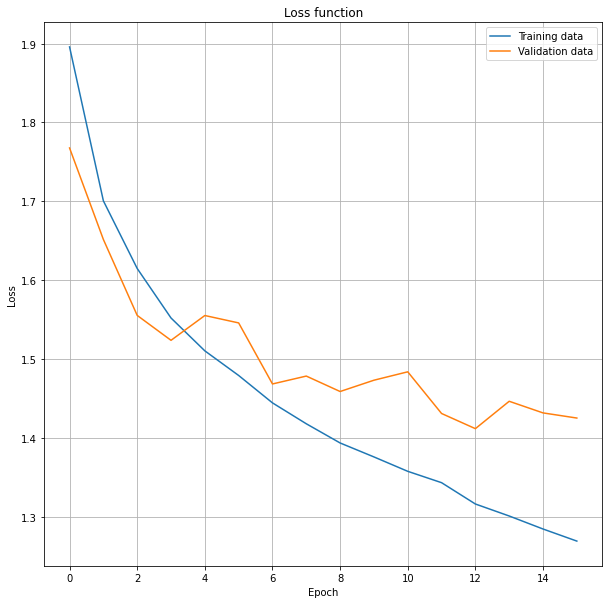

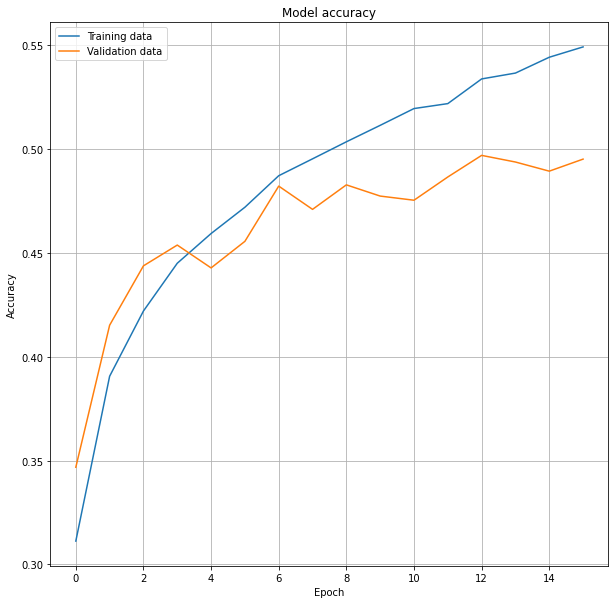

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

In [ ]:
 model.evaluate(ds_test, verbose=2)



79/79 - 0s - loss: 1.4066 - accuracy: 0.5031


[1.4066221714019775, 0.5030999779701233]

> To save a model

In [ ]:
model.save('cifar')

INFO:tensorflow:Assets written to: cifar/assets


INFO:tensorflow:Assets written to: cifar/assets


> To visualize the model

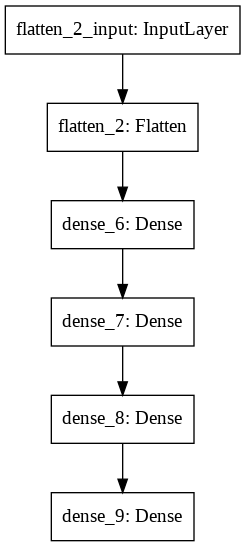

In [ ]:
tf.keras.utils.plot_model(model)

## Adding further layers

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy', 'mse'],
)

# Summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 444,170
Trainable params: 444,170
Non-trainable params: 0
________________________________________________

In [ ]:
hist = model.fit(
    ds_train,
    epochs=40,
    validation_data=ds_val,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=3) #Here we are using ds_test as the validation and testing the performance on test dat throuh that. If we use teh validation data, we will calculate the test score on test data seperately.
)

Epoch 1/40
352/352 [==============================] - 4s 10ms/step - loss: 2.0048 - accuracy: 0.2608 - mse: 27.2966 - val_loss: 1.7482 - val_accuracy: 0.3662 - val_mse: 28.8174
Epoch 2/40
352/352 [==============================] - 3s 10ms/step - loss: 1.7180 - accuracy: 0.3770 - mse: 27.6668 - val_loss: 1.6371 - val_accuracy: 0.4070 - val_mse: 28.8208
Epoch 3/40
352/352 [==============================] - 3s 10ms/step - loss: 1.6244 - accuracy: 0.4114 - mse: 27.4774 - val_loss: 1.5595 - val_accuracy: 0.4376 - val_mse: 28.8231
Epoch 4/40
352/352 [==============================] - 4s 10ms/step - loss: 1.5746 - accuracy: 0.4357 - mse: 27.8289 - val_loss: 1.5600 - val_accuracy: 0.4370 - val_mse: 28.8233
Epoch 5/40
352/352 [==============================] - 3s 10ms/step - loss: 1.5222 - accuracy: 0.4502 - mse: 27.4121 - val_loss: 1.5301 - val_accuracy: 0.4526 - val_mse: 28.8254
Epoch 6/40
352/352 [==============================] - 4s 10ms/step - loss: 1.4757 - accuracy: 0.4704 - mse: 27.6005

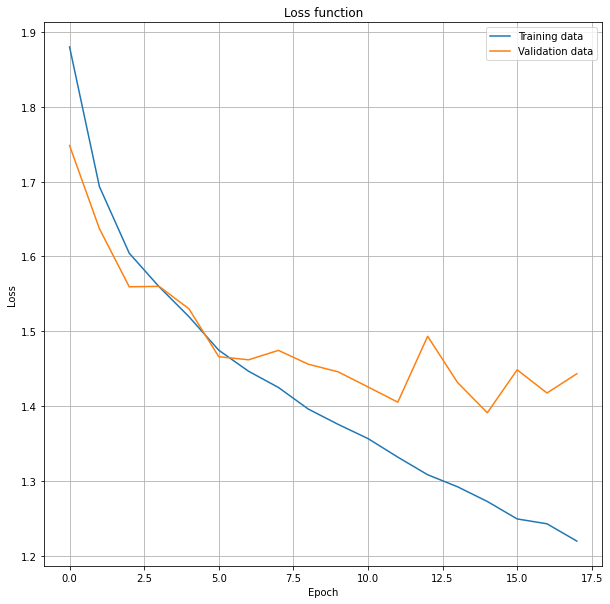

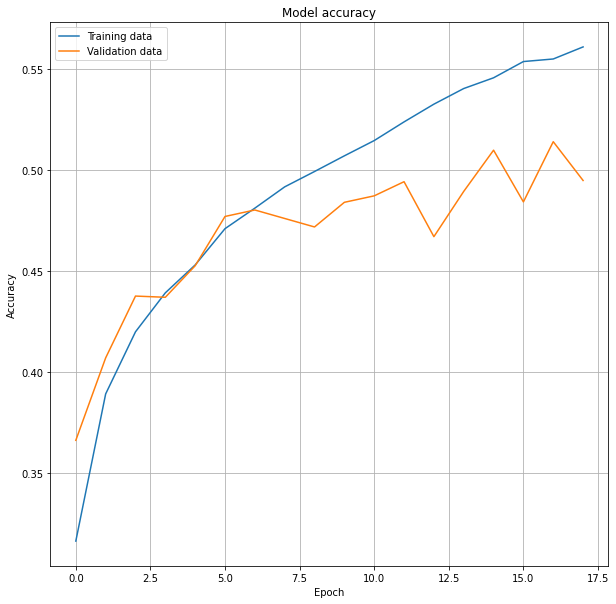

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

In [ ]:
 model.evaluate(ds_test, verbose=2)

79/79 - 0s - loss: 1.4515 - accuracy: 0.4965 - mse: 27.6443


[1.4515241384506226, 0.4964999854564667, 27.644256591796875]

5 hidden layers

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy', 'mse'],
)

# Summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total params: 444,170
Trainable params: 444,170
Non-trainable params: 0
________________________________________________

In [ ]:
hist = model.fit(
    ds_train,
    epochs=40,
    validation_data=ds_val,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=3) #Here we are using ds_test as the validation and testing the performance on test dat throuh that. If we use teh validation data, we will calculate the test score on test data seperately.
)

Epoch 1/40
352/352 [==============================] - 4s 11ms/step - loss: 2.0079 - accuracy: 0.2570 - mse: 27.2564 - val_loss: 1.7103 - val_accuracy: 0.3830 - val_mse: 28.8175
Epoch 2/40
352/352 [==============================] - 3s 10ms/step - loss: 1.7122 - accuracy: 0.3830 - mse: 27.6873 - val_loss: 1.6846 - val_accuracy: 0.3834 - val_mse: 28.8202
Epoch 3/40
352/352 [==============================] - 4s 10ms/step - loss: 1.6258 - accuracy: 0.4172 - mse: 27.4315 - val_loss: 1.5806 - val_accuracy: 0.4222 - val_mse: 28.8226
Epoch 4/40
352/352 [==============================] - 3s 10ms/step - loss: 1.5778 - accuracy: 0.4354 - mse: 27.3815 - val_loss: 1.5567 - val_accuracy: 0.4420 - val_mse: 28.8229
Epoch 5/40
352/352 [==============================] - 3s 10ms/step - loss: 1.5156 - accuracy: 0.4565 - mse: 27.4786 - val_loss: 1.5267 - val_accuracy: 0.4476 - val_mse: 28.8243
Epoch 6/40
352/352 [==============================] - 3s 10ms/step - loss: 1.4852 - accuracy: 0.4635 - mse: 27.3978

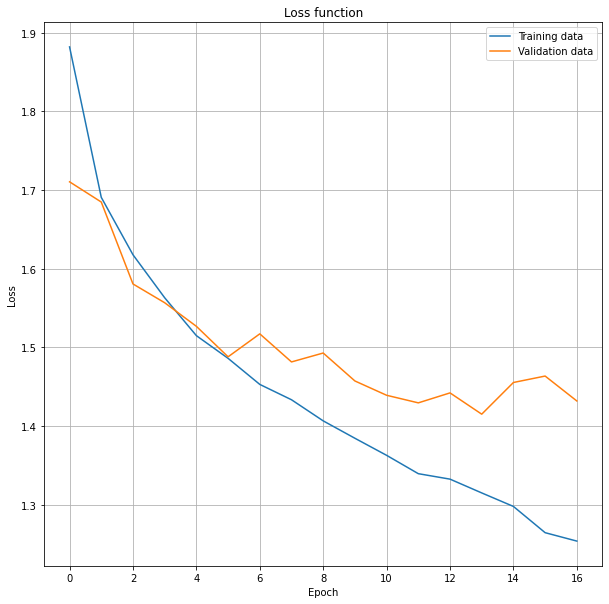

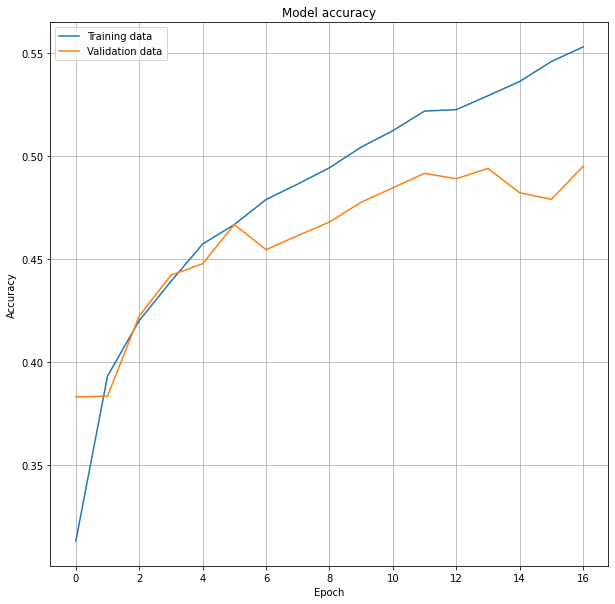

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

In [ ]:
 model.evaluate(ds_test, verbose=2)

79/79 - 0s - loss: 1.4500 - accuracy: 0.4871 - mse: 27.6412


[1.4499566555023193, 0.4871000051498413, 27.6412410736084]

## Changing optimizer hyperparameter

In [ ]:
# Step 3: Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1290      
Total params: 427,658
Trainable params: 427,658
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(
    ds_train,
    epochs=40,
    validation_data=ds_val,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=3) 
)

Epoch 1/40
352/352 [==============================] - 4s 10ms/step - loss: 3.0398 - accuracy: 0.1988 - val_loss: 1.8664 - val_accuracy: 0.3288
Epoch 2/40
352/352 [==============================] - 3s 9ms/step - loss: 1.8296 - accuracy: 0.3349 - val_loss: 1.7436 - val_accuracy: 0.3720
Epoch 3/40
352/352 [==============================] - 3s 9ms/step - loss: 1.7682 - accuracy: 0.3626 - val_loss: 1.7560 - val_accuracy: 0.3630
Epoch 4/40
352/352 [==============================] - 3s 9ms/step - loss: 1.7262 - accuracy: 0.3773 - val_loss: 1.7922 - val_accuracy: 0.3670
Epoch 5/40
352/352 [==============================] - 3s 9ms/step - loss: 1.7238 - accuracy: 0.3791 - val_loss: 1.7052 - val_accuracy: 0.3874
Epoch 6/40
352/352 [==============================] - 3s 9ms/step - loss: 1.6876 - accuracy: 0.3956 - val_loss: 1.7476 - val_accuracy: 0.3728
Epoch 7/40
352/352 [==============================] - 3s 9ms/step - loss: 1.6921 - accuracy: 0.3892 - val_loss: 1.7001 - val_accuracy: 0.3860
Epoch

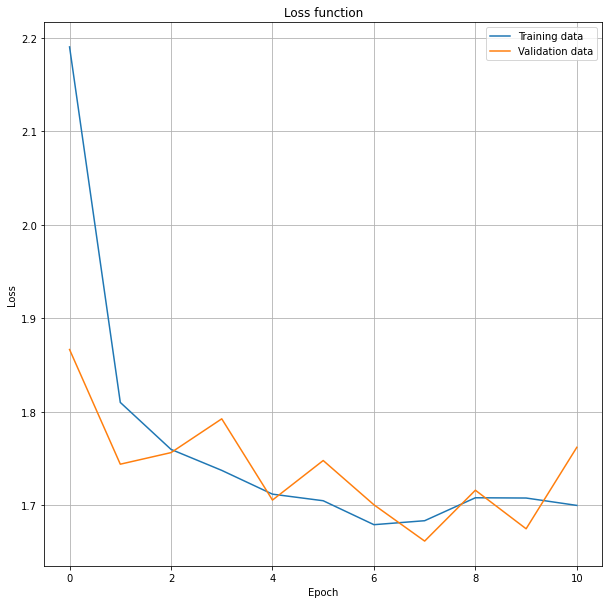

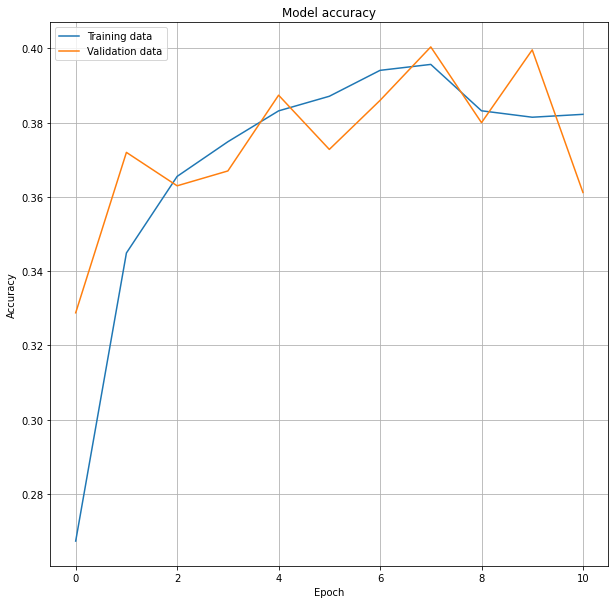

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

In [ ]:
 model.evaluate(ds_test, verbose=2)

79/79 - 0s - loss: 1.7519 - accuracy: 0.3588


[1.7518619298934937, 0.3587999939918518]

The learning is more erratic with higher optimizer parameter, which is expected.

## Changing optimizer

We observe here that SGD train slowly so if itstart from a far away weights it will need more epochs.

In [ ]:
# Step 3: Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy','mse',tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

# Summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
Total params: 427,658
Trainable params: 427,658
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(
    ds_train,
    epochs=150,
    validation_data=ds_val,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=4) 
)

Epoch 1/150
352/352 [==============================] - 4s 9ms/step - loss: 2.2938 - accuracy: 0.1363 - mse: 27.4258 - acc: 0.1363 - val_loss: 2.2254 - val_accuracy: 0.1978 - val_mse: 28.8031 - val_acc: 0.1978
Epoch 2/150
352/352 [==============================] - 3s 9ms/step - loss: 2.2140 - accuracy: 0.2045 - mse: 27.2364 - acc: 0.2045 - val_loss: 2.1607 - val_accuracy: 0.2342 - val_mse: 28.8036 - val_acc: 0.2342
Epoch 3/150
352/352 [==============================] - 3s 9ms/step - loss: 2.1512 - accuracy: 0.2439 - mse: 27.4901 - acc: 0.2439 - val_loss: 2.1026 - val_accuracy: 0.2642 - val_mse: 28.8043 - val_acc: 0.2642
Epoch 4/150
352/352 [==============================] - 3s 9ms/step - loss: 2.0935 - accuracy: 0.2608 - mse: 27.4008 - acc: 0.2608 - val_loss: 2.0559 - val_accuracy: 0.2804 - val_mse: 28.8051 - val_acc: 0.2804
Epoch 5/150
352/352 [==============================] - 3s 9ms/step - loss: 2.0491 - accuracy: 0.2797 - mse: 27.6133 - acc: 0.2797 - val_loss: 2.0191 - val_accuracy:

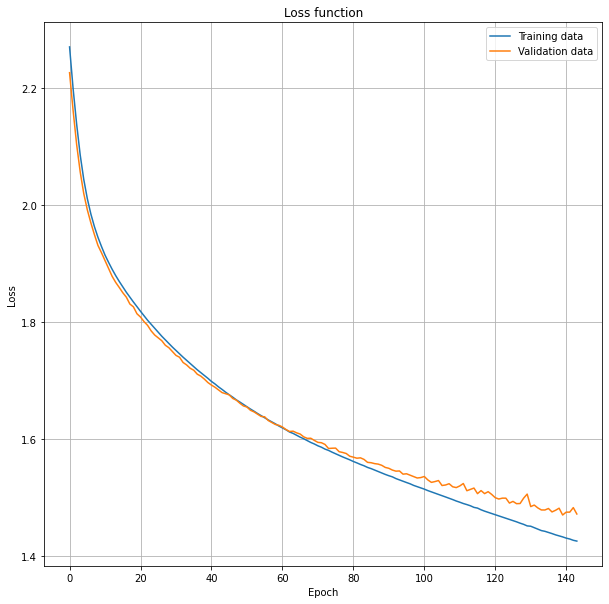

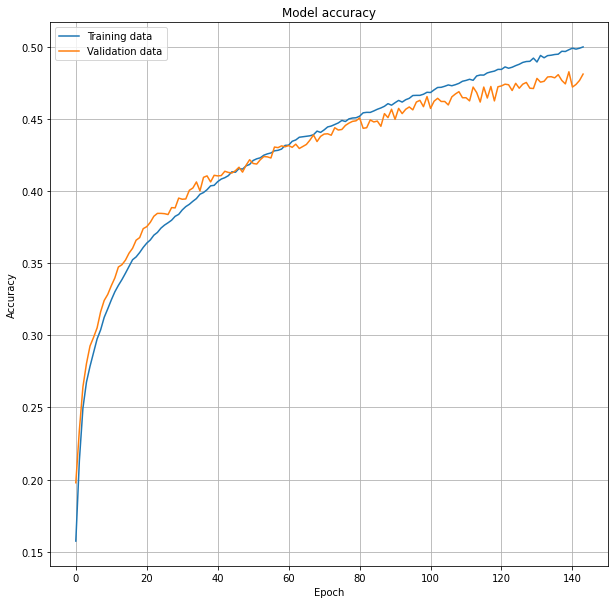

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

Learning with Stochastic Gradient decent is slower with rate 0.01, which is expected.

In [ ]:
 model.evaluate(ds_test, verbose=2)

79/79 - 0s - loss: 1.4749 - accuracy: 0.4814 - mse: 27.6323 - acc: 0.4814


[1.4749281406402588,
 0.4814000129699707,
 27.632341384887695,
 0.4814000129699707]

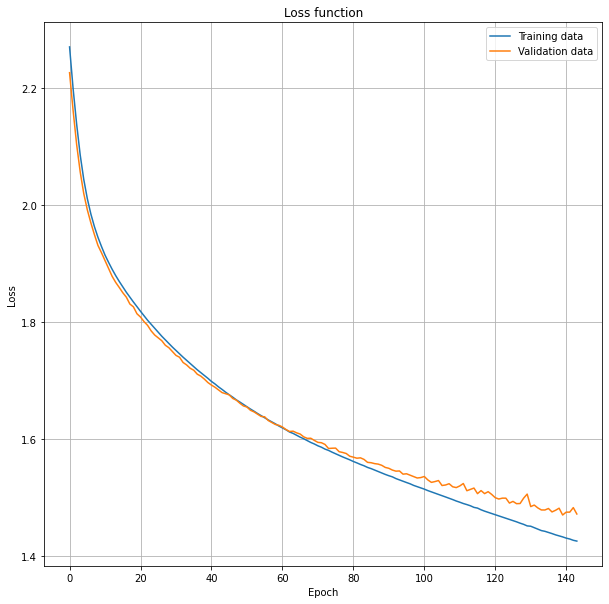

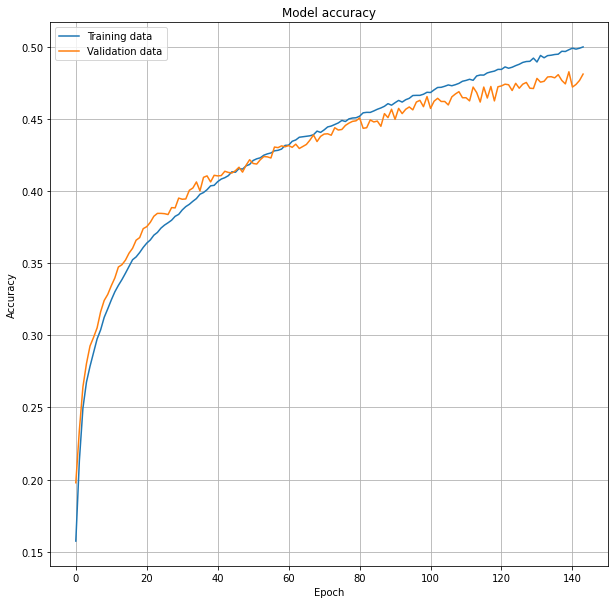

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

#  Numpy arrays

In this section we will work with numpy arrays to train and evaluate the model. As noted earlier this allows easier analysis and enable us using more metric while training.

In [93]:
(X_train, y_train),(X_test,y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [94]:
X_train.shape

(50000, 32, 32, 3)

Normalize and hot encode the data

In [95]:
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)) 
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))
class_names = np.unique(y_train)
 #one hot encoding of the targets 
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [96]:
y_train.shape #encoded in the vector

(50000, 10)

## Model

> We can train the model and use different metrics while training

In [ ]:
# Step 3: Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.Recall(),'accuracy','mse',tf.keras.metrics.Precision()] 
)

# Summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1290      
Total params: 427,658
Trainable params: 427,658
Non-trainable params: 0
_________________________________________________________________


> The default batch size is 32

In [ ]:
hist = model.fit( 
    X_train,y_train,
    epochs=50,
    validation_split=0.2,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=3) 
)

Epoch 1/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9939 - recall: 0.0392 - accuracy: 0.2680 - mse: 0.0826 - precision: 0.5412 - val_loss: 1.7279 - val_recall: 0.1155 - val_accuracy: 0.3854 - val_mse: 0.0749 - val_precision: 0.6346
Epoch 2/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7157 - recall: 0.1352 - accuracy: 0.3858 - mse: 0.0744 - precision: 0.6214 - val_loss: 1.7162 - val_recall: 0.1832 - val_accuracy: 0.3979 - val_mse: 0.0740 - val_precision: 0.5919
Epoch 3/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6369 - recall: 0.1735 - accuracy: 0.4130 - mse: 0.0718 - precision: 0.6383 - val_loss: 1.6056 - val_recall: 0.1917 - val_accuracy: 0.4263 - val_mse: 0.0706 - val_precision: 0.6527
Epoch 4/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5777 - recall: 0.2035 - accuracy: 0.4305 - mse: 0.0699 - precision: 0.6535 - val_loss: 1.5829 - val_recall: 0.2130 - val_accuracy: 0.4340 - val_mse:

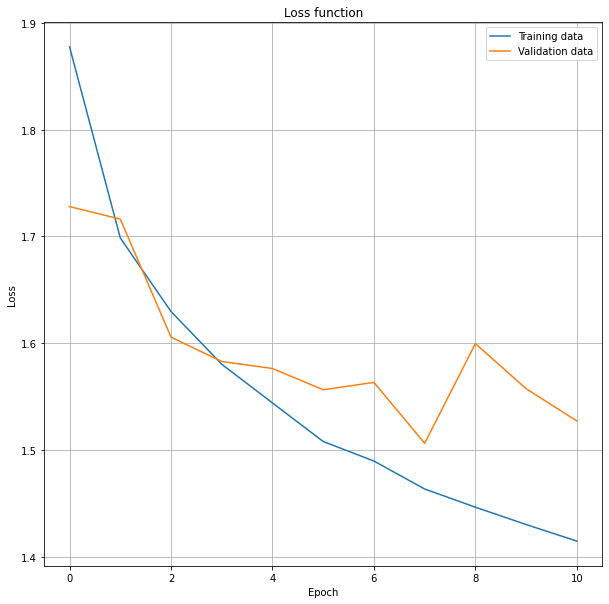

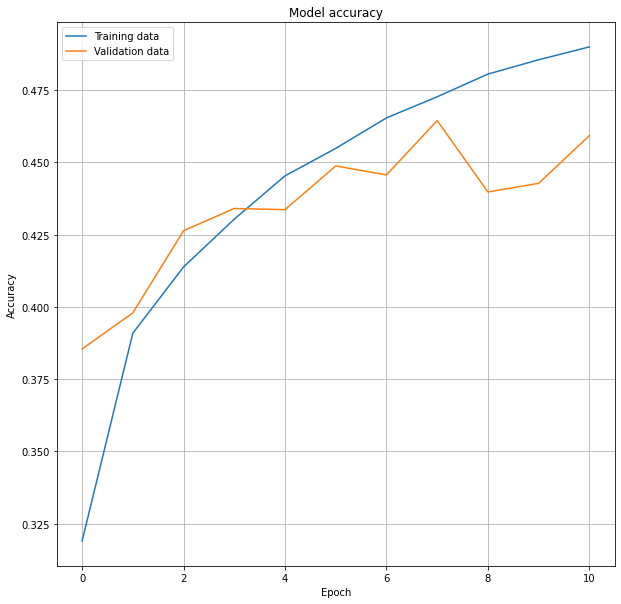

In [ ]:
# Plot the training progress
fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Validation data'])

accuracy: 0.5482

## Metrics evaluation

In [ ]:
 model.evaluate(X_test,y_test, verbose=2)

313/313 - 1s - loss: 1.5018 - recall: 0.2674 - accuracy: 0.4663 - mse: 0.0668 - precision: 0.6572


[1.5017766952514648,
 0.26739999651908875,
 0.46630001068115234,
 0.06676972657442093,
 0.6571639180183411]

accuracy: 0.4707

In [109]:
y_testLabel = np.argmax(y_test,axis=1) #y_test is hot encoded so we reshape it to match with 

In [ ]:
y_predict = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [99]:
y_predict = np.argmax(model.predict(X_test), axis=-1)

## Metric evaluation per class

> We can use classification report to eveluate how the model is performing for each class

In [103]:
from sklearn.metrics import classification_report,confusion_matrix 
print("Classification report \n=======================") 
print(classification_report(y_true=y_testLabel, y_pred=y_predict))

Classification report 
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1000
           1       0.59      0.56      0.58      1000
           2       0.35      0.31      0.33      1000
           3       0.33      0.25      0.29      1000
           4       0.40      0.38      0.39      1000
           5       0.40      0.39      0.39      1000
           6       0.46      0.55      0.50      1000
           7       0.53      0.52      0.53      1000
           8       0.53      0.66      0.59      1000
           9       0.50      0.53      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



We visualize some of the predictions

> We can see how some images are presdicted accurately but overall not a reliable model for image classification on CIFAR10

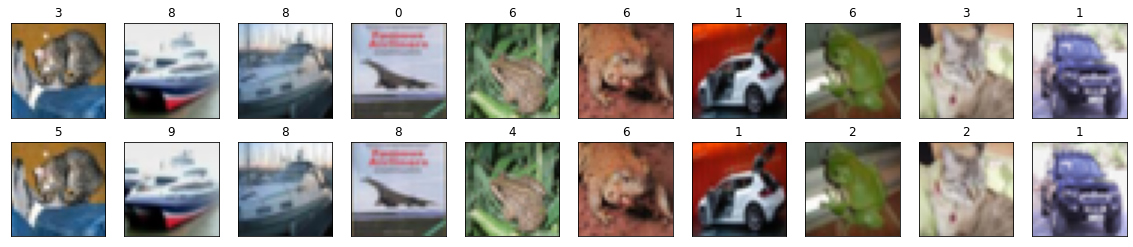

In [116]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title(y_testLabel[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(X_test[i])
  plt.title(y_predict[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Conclusion

> The basic feedforward neural networks are not as good for the image classification but we can see the power of these networks over classic linear algorithms.

> Adding more layers increase the train accuracy significantly but not necessarily the validation and test accuracy indicating overfitting.

> Adding more layers with a callback to stop training when diverging from validation accuracy is a better appraoch.

> TF Datasets are great to easily optimize performance. It is easy to cache data and process them when big to download the data.

> We found it to be a bit difficult to work with afterwards as train and test data it is in prefetch dataset type at the end of pipeline. So have to convert back to use standard model eveluation reports.

>  Numpy arrays are good with smaller datasets and many modules of classical fnctions can be used.

